## Work by Lok Tung Li

# Preparation and general comments

We will work this dataset on Google Colab. We first employ standard methods to upload and read the dataset through `files` and `pandas`.

In [1]:
#Upload and read file

from google.colab import files
import pandas as pd

uploaded = files.upload()
!unzip weekly_media_sample.zip
df = pd.read_csv('weekly_media_sample.csv')

Saving weekly_media_sample.zip to weekly_media_sample.zip
Archive:  weekly_media_sample.zip
  inflating: weekly_media_sample.csv  


Next, we change the index to `datetime` index to slightly simplify the dataset, and we also print basic statistics of the dataset to obatain insights.

In [2]:
#changing index to datetime index
df['DateTimeIndex']= pd.to_datetime(df['DATE'])
df = df.set_index(keys=['DateTimeIndex'])
df = df.drop(['X','DATE'],axis = 1)
#print basic statistics
print(df.describe())

            revenue      media1_S       media2_S       media3_S  \
count  2.080000e+02  2.080000e+02     208.000000     208.000000   
mean   1.822143e+06  1.113277e+05   27964.741987   64369.734789   
std    7.162286e+05  2.141877e+05   48623.026738   94810.914100   
min    6.722500e+05  0.000000e+00       0.000000       0.000000   
25%    1.165211e+06  0.000000e+00       0.000000       0.000000   
50%    1.874514e+06  0.000000e+00       0.000000       0.000000   
75%    2.378407e+06  1.380503e+05   35758.750000  108690.366986   
max    3.827520e+06  1.185349e+06  239417.333333  462011.742240   

       competitor_sales    newsletter  
count      2.080000e+02    208.000000  
mean       5.538025e+06  22386.523077  
std        2.077192e+06  19104.164517  
min        2.240235e+06    301.000000  
25%        3.589581e+06   9010.500000  
50%        5.538524e+06  19401.650000  
75%        7.311814e+06  27546.500000  
max        9.984742e+06  96236.000000  


There are several comments we would like to add to the dataset. First of all, it is a media spending data, where `media_1`, `media_2`, `media_3` might be the paid ad spend on say Google, Facebook, Linkedin or other major media ad platform.

Secondly, we see that for the three media_S columns, more than 50% of the entries are 0. By taking a look at the actual csv file, we see that the strategies on investing using different combinations are quite sparse. Say sometimes investing only on `media_2` and `media_3`, or sometimes investing only on `media_1`, or even not investing on all 3 paid medias at all.

Finally, in the brief description, it is written "Revenue (ROI)". However, it is quite impossible for the ROI to be at such a high value, we suspect that is a mistake, and the `revenue` represents true revenue, not ROI.

## Exploratory Data Analysis

Next, we will do a `pairplot`, to investigate the pairwise relation between each of the columns. 

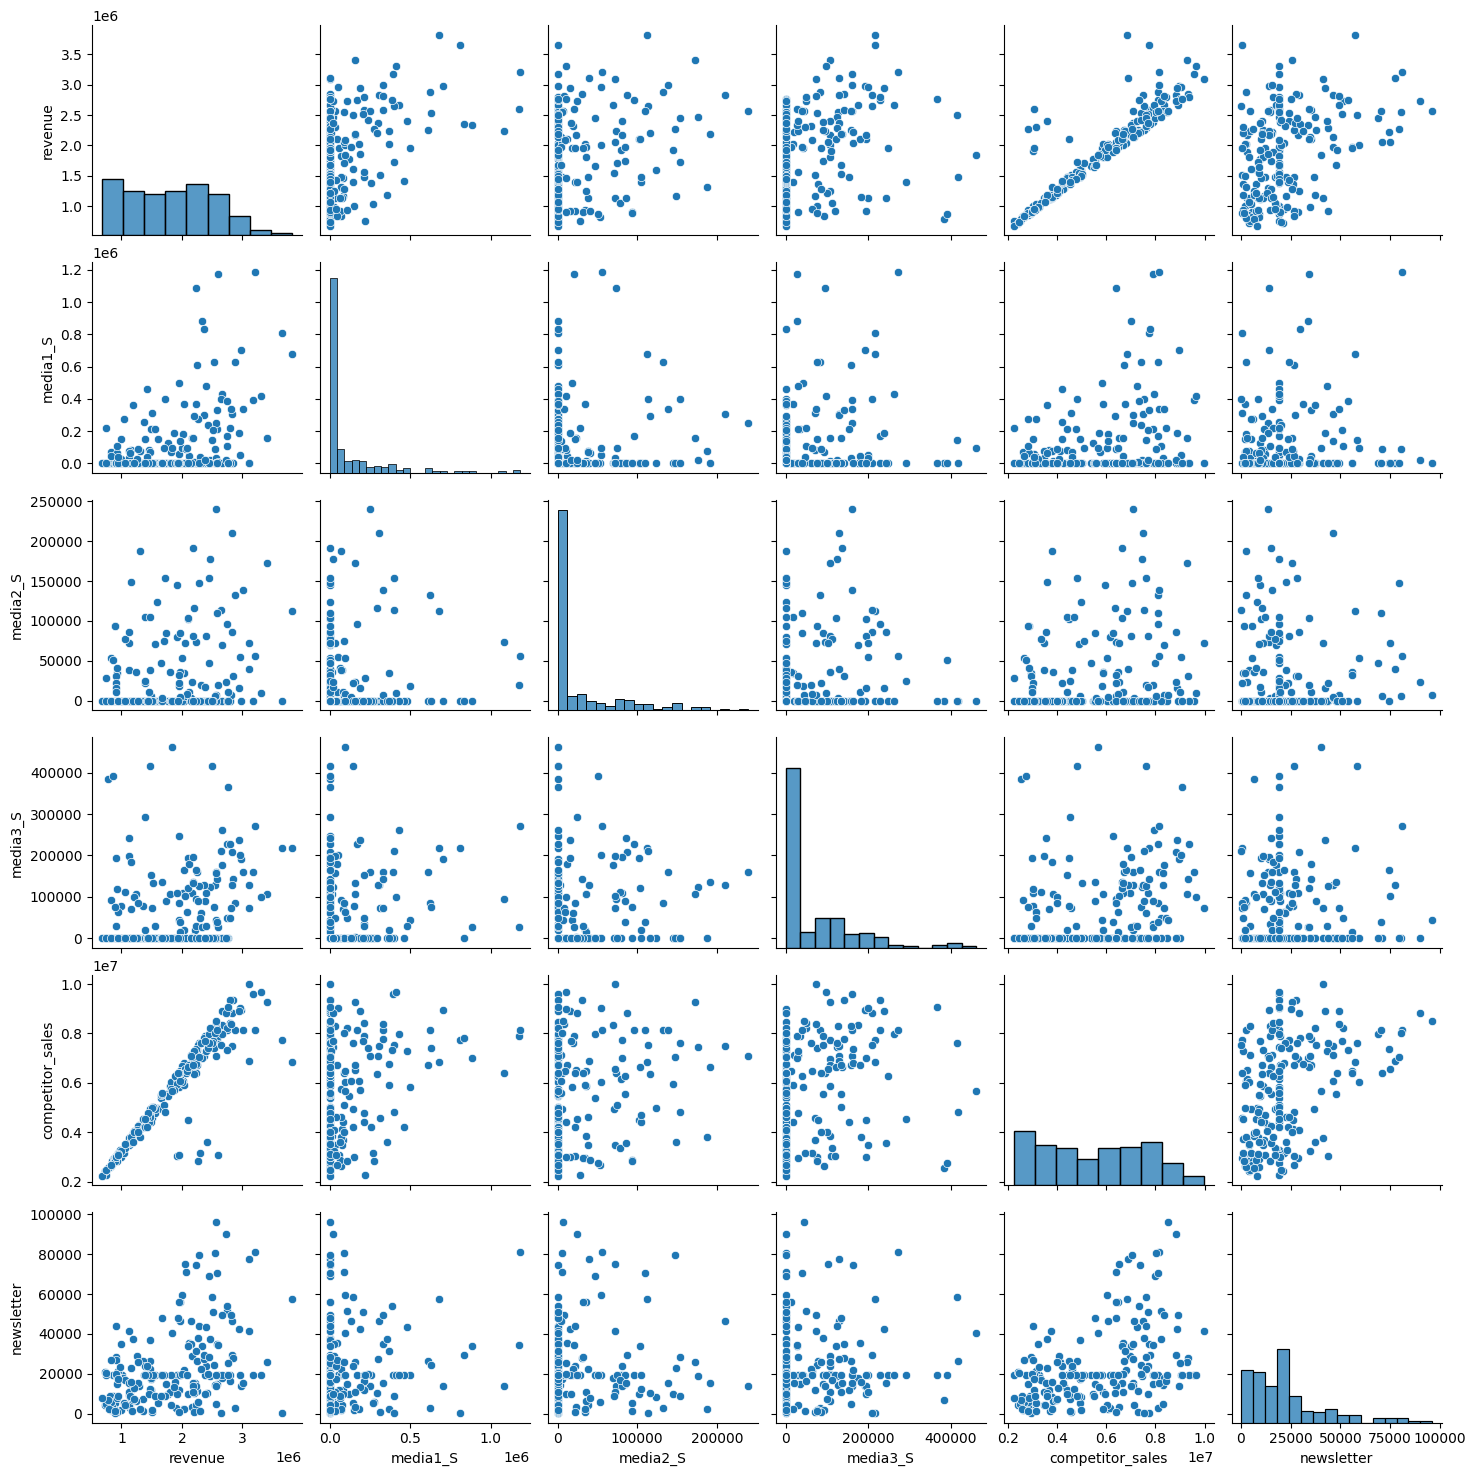

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df)
plt.show()

We are particularly interested in the two to fifth column of the first row. We see that due to the excessive zero entries on media columns, there are many points on the y-axis on the revenue agains media plot. We also notice that there is a strong positive linear relationship between revenue and competitor_sales.

# Part 1: Classical Marketing Data Modelling

## 1a: Modelling

### Model Selection, Q1a(i)

To determine which model should we use, we calculate the Hoyer measures of observation, to see the sparseness. As there are quite many zero entries in the three media columns, the spareness helps us to determine whether it is appropriate to use multiple linear regression model.

In [4]:
import numpy as np
import math
sparse = []
a = math.sqrt(df.shape[0])
for i in df.columns:
  sparse.append((a - (np.linalg.norm(df[i],1)/np.linalg.norm(df[i],2)))/(a-1))
print(sparse)

[0.07415815811487425, 0.5780128002910403, 0.537830593909608, 0.4699559643189998, 0.06814195392872377, 0.25633183434597295]


As the sparseness is not too high, we will use ordinary multiple linear regression. We choose to include all variables in our model, since from the beginning we would like be safe. Furthermore, in principle, one could expect there are revenue generated from all paid medias as well as newsletter subscription.

To perfrom the linear regression, we will first use the patsy package to add intercept to our dataset. Secondly, we will write down the expression as `expr`. Next, we perform the train-test split, then use `OLS` model from `statsmodels` package. After that, we print the summary of the result of regression.

In [5]:
import statsmodels.api as sm
from patsy import dmatrices

expr = 'revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter'
#add intercept using patsy
y_train_intercept, X_train_intercept = dmatrices(expr, df.iloc[:200], return_type='dataframe')
y_test_intercept, X_test_intercept = dmatrices(expr, df.iloc[200:], return_type='dataframe')
re = sm.OLS(y_train_intercept, X_train_intercept).fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     244.8
Date:                Thu, 11 May 2023   Prob (F-statistic):           9.58e-82
Time:                        15:22:10   Log-Likelihood:                -2781.0
No. Observations:                 200   AIC:                             5574.
Df Residuals:                     194   BIC:                             5594.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         9.959e+04   5.43e+04      1.835      0.068   -7448.972    2.07e+05
media1_S             0.5041      0.093      5.433      0.000       0.321       0.687
media2_S             0.9641      0.410      2.353      0.020       0.156       1.772
media3_S             0.3407      0.223      1.527      0.128      -0.099       0.781
competitor_sales     0.2885      0.011     25.959      0.000       0.267       0.310
newsletter           0.9219      1.164      0.792      0.429      -1.375       3.218
==============================================================================
Omnibus:                      186.740   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2503.306
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      18.577   Cond. No.                     1.66e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpreting Result, Q1a(ii)

To interpret the result, we look at the p-value. We see that the competitor sales, media1_S and media2_S has strong evidence to influence the revenue. For media 3 and newsletter, the null hypothesis that they have no effect on revenue is retained. Roughly speaking, when the spend on media1_S (media2_S, competitor_sales respectively) is increased by 1 unit, the revenue will go up by 0.5 unit (0.96 unit, 0.29 unit respectively).

### Limitation, Q1a(iii)

In the context of media marketing, there are several limitations of the model. First of all, fundamentally the revenue did not consists of organic search, as well as direct sales and referral sales. 

Secondly, linear regression did not take Law of Diminishing Marginal Returns into account. This is particularly true in the context of google ad biding. When one is biding using a large amount that is greater than all other competitor, the revenue would be the same as biding just by 0.1 dollar more than the highest competitor. Similarly, the revenue is still 0 even one bid for 0.1 dollar less than the highest competitor.

## 1b: Prediction 

### Prediction and Visualization, Q1b(i)

Next, we print out the prediction table to prepare for the prediction.

In [6]:
predictions = re.get_prediction(X_test_intercept)
frame = predictions.summary_frame(alpha=0.05)
print(frame)

                       mean       mean_se  mean_ci_lower  mean_ci_upper  \
DateTimeIndex                                                             
2016-06-06     2.474107e+06  43693.745117   2.387932e+06   2.560283e+06   
2016-06-13     2.351558e+06  86884.215884   2.180199e+06   2.522917e+06   
2016-06-20     2.561615e+06  87450.010476   2.389140e+06   2.734090e+06   
2016-06-27     2.470159e+06  63144.395708   2.345621e+06   2.594696e+06   
2016-07-04     2.166562e+06  35208.005040   2.097122e+06   2.236001e+06   
2016-07-11     2.354747e+06  44741.197168   2.266505e+06   2.442988e+06   
2016-07-18     2.760714e+06  79759.627099   2.603407e+06   2.918021e+06   
2016-07-25     2.858430e+06  80312.942417   2.700031e+06   3.016828e+06   

               obs_ci_lower  obs_ci_upper  
DateTimeIndex                              
2016-06-06     1.937255e+06  3.010959e+06  
2016-06-13     1.794649e+06  2.908467e+06  
2016-06-20     2.004362e+06  3.118868e+06  
2016-06-27     1.925830e+06  

Next, we obtain a pandas dataframe to make the plotting easier. Notice that the obs_ci denotes the prediction interval, and the mean_ci denotes the confidence interval. We will also rename them as PI, and CI respectively.

In [7]:
conf_df = pd.concat([y_test_intercept, frame[['mean','obs_ci_lower','obs_ci_upper','mean_ci_lower', 'mean_ci_upper']]], axis = 1)
conf_df.columns=['Revenue','Predictions','Lower PI', 'Upper PI','Lower CI', 'Upper CI']
conf_df.head()

,Revenue,Predictions,Lower PI,Upper PI,Lower CI,Upper CI
DateTimeIndex,,,,,,
2016-06-06,2.510952e+06,2.474107e+06,1.937255e+06,3.010959e+06,2.387932e+06,2.560283e+06
2016-06-13,2.275620e+06,2.351558e+06,1.794649e+06,2.908467e+06,2.180199e+06,2.522917e+06
2016-06-20,2.505162e+06,2.561615e+06,2.004362e+06,3.118868e+06,2.389140e+06,2.734090e+06
2016-06-27,2.456240e+06,2.470159e+06,1.925830e+06,3.014487e+06,2.345621e+06,2.594696e+06
2016-07-04,2.182825e+06,2.166562e+06,1.632141e+06,2.700983e+06,2.097122e+06,2.236001e+06


Finally, we plot the prediction, confidence interval and prediction interval on the graph, so we can compare with the actual revenue curve.

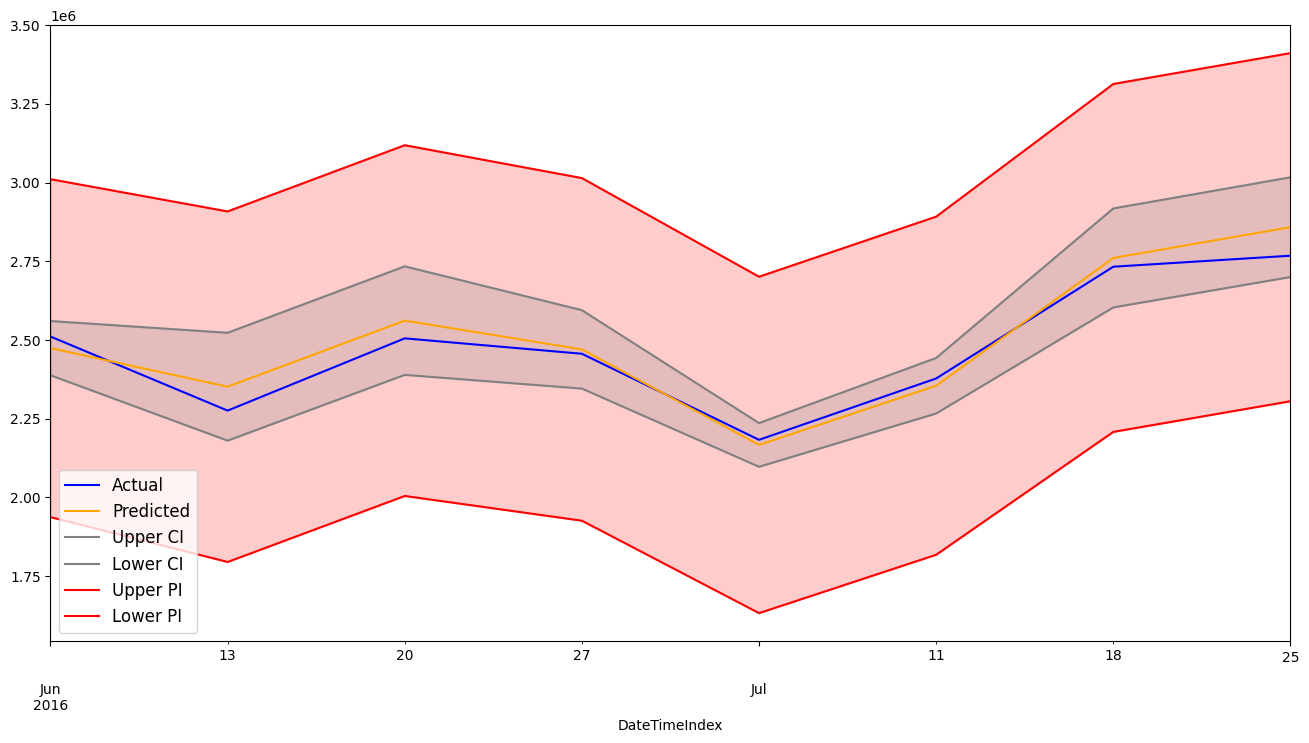

In [8]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)

x = conf_df.index.values

upper_ci = conf_df['Upper CI']
lower_ci = conf_df['Lower CI']
upper_pi = conf_df['Upper PI']
lower_pi = conf_df['Lower PI']

conf_df['Revenue'].plot(color = 'blue', label = 'Actual')
conf_df['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper_ci.plot(color = 'grey', label = 'Upper CI')
lower_ci.plot(color = 'grey', label = 'Lower CI')
upper_pi.plot(color = 'red', label = 'Upper PI')
lower_pi.plot(color = 'red', label = 'Lower PI')


plt.legend(loc = 'lower left', fontsize = 12)

plt.fill_between(x, lower_pi, upper_pi, color='red', alpha=0.2)

plt.fill_between(x, lower_ci, upper_ci, color='grey', alpha=0.2)


plt.show()

### Predictive Performance, Q1b(ii)

To assess the performance, we will compute the mean absolute error and root mean square error using `sklearn` package.

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(conf_df['Revenue'],conf_df['Predictions'])
rmse = mean_squared_error(conf_df['Revenue'],conf_df['Predictions'],squared=False)
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 42613.44592092652, RMSE: 50361.289034879985


## 1c: Temporal effects

### Temporal effects in marketing dataset, Q1c(i)

We agree that it is important to account for temporal effect in media marketing dataset. 

Seasonal trend is an important factor affecting the revenue. For example, retail will usually see increase in revenue near Christmas and Black Friday. Education industry will see increase in revenue before the start of an academic year.

The general performance of the company or more generally the industry will also affect the revenue. For example if the industry is growing fast, one can expect an upward trend in revenue.

### Times series SARIMAX Model, Q1c(ii)

Before we perform time series analysis, we will first plot the revenue agains datetime to have a look.

<Axes: xlabel='DateTimeIndex', ylabel='revenue'>

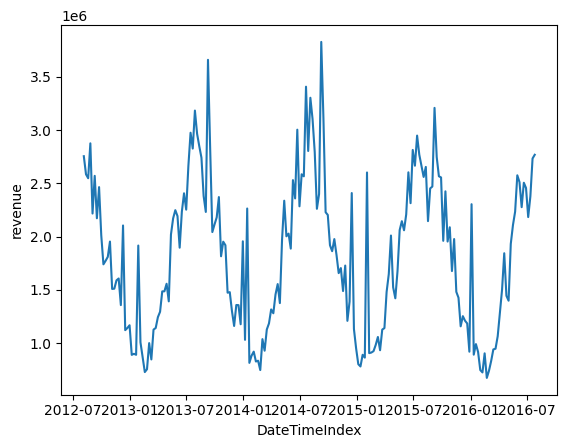

In [10]:
sns.lineplot(data=df['revenue'])

We can see there is strong seasonal trend with seasonal period roughly equals to 12 months. Taking a further look into the dataset, we see that there are roughly 2 peaks in all three seasonal period, one peak is at about 1 month before September, and another peak is at the first week of September. As September is the start of an academic year, this revenue makes sense for say, education industry.

We will use SARIMAX model to include temporal consideration. First we do an ACF plot, to measure the autocorrelation.

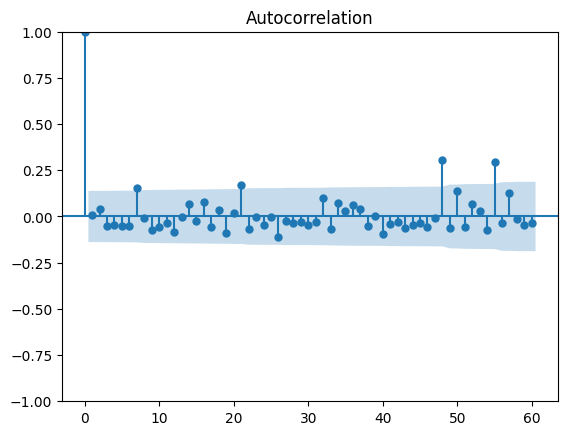

In [11]:
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(re.resid, lags=60)
plt.show()

There are strong autocorrelations near lag-52, which verifies our observation in the line plot above. Next, we perform a lag-52 difference, and plot the ACF once again, to see whether we need to take one more difference.

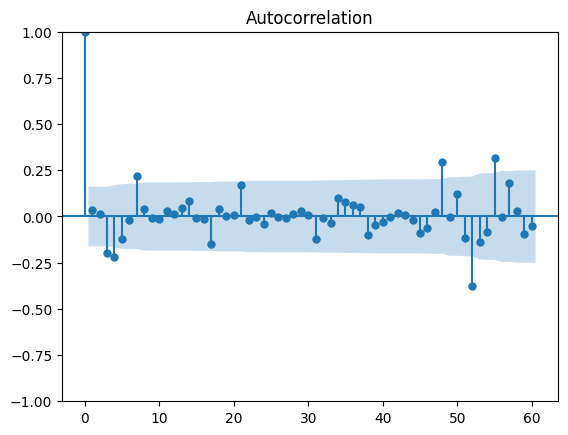

In [12]:
olsr_resid_52 = re.resid.diff(periods=52)
olsr_resid_52 = olsr_resid_52.dropna()
tsa.plot_acf(olsr_resid_52, lags=60)
plt.show()

From this ACF plot, we see that there is no need to take difference once more.

Now, we want to use SARIMAX model with seasonal order `(0,1,1)52` to perform our time series analysis. Unfortunately, looking into the documentation of `ARIMA` model in `statsmodels` package, one see that for `seasonal_order` taking effect, at least 5 seasonal period is needed. Otherwise, many parameter will just be 0, and seasonal effect will not be taken into account.

Therefore, in order the take temporal effect into account, we will try a (1,0,1)-(0,1,1)52 model, but keep in mind that only the (1,0,1) part is having effect. 

We drop the intercept and fit the training data into SARIMAX model.

In [13]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA
X_train = X_train_intercept.drop('Intercept', axis=1)
X_train = X_train.asfreq('W-Mon')
y_train = y_train_intercept.asfreq('W-Mon')
X_test = X_test_intercept.drop('Intercept',axis=1)
X_test = X_test.asfreq('W-Mon')
y_test = y_test_intercept.asfreq('W-Mon')

sarimax_model = ARIMA(endog=y_train, exog=X_train,order=(1,0,1), seasonal_order=(0,1,1,52))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                          revenue   No. Observations:                  200
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -2089.326
Date:                          Thu, 11 May 2023   AIC                           4196.652
Time:                                  15:23:16   BIC                           4223.627
Sample:                              08-06-2012   HQIC                          4207.612
                                   - 05-30-2016                                         
Covariance Type:                            opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
media1_S             0.5270      0.286      1.841      0.066      -0.034       1.088
media2_S             0.7288      1.444      0.505      0.614      -2.102       3.560
media3_S             0.0016      0.630      0.003      0.998      -1.233       1.237
competitor_sales     0.3204      0.044      7.208      0.000       0.233       0.408
newsletter          -0.3816      2.602     -0.147      0.883      -5.481       4.718
ar.L1                0.7361      0.604      1.218      0.223      -0.448       1.920
ma.L1               -0.8062      0.573     -1.407      0.159      -1.929       0.316
ma.S.L52            -0.6724      0.136     -4.932      0.000      -0.940      -0.405
sigma2            1.504e+11   1.12e-10   1.34e+21      0.000     1.5e+11     1.5e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               897.30
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             2.75
Prob(H) (two-sided):                  0.70   Kurtosis:                        13.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.86e+36. Standard errors may be unstable.
"""

### Times series analysis suitability, Q1c(iii)

We first look at the result of Ljung-Box test in the last section. We see that there is strong evidence that the residual have no autocorrelation, which is good.

To analyze whether the time series model is suitable, we will try to do a time seris forecast, and compare the forecast with the test data. The forecase is done simply by `get_forecast`.

In [14]:
forecast = sarimax_results.get_forecast(steps=8, exog=X_test)
frame_arima = forecast.summary_frame()
print(frame_arima)

revenue             mean        mean_se  mean_ci_lower  mean_ci_upper
2016-06-06  2.456242e+06  392442.154704   1.687069e+06   3.225414e+06
2016-06-13  1.907275e+06  393404.943199   1.136215e+06   2.678334e+06
2016-06-20  2.453770e+06  393925.275693   1.681691e+06   3.225850e+06
2016-06-27  2.450629e+06  394206.191820   1.677999e+06   3.223259e+06
2016-07-04  2.136884e+06  394356.929868   1.363958e+06   2.909809e+06
2016-07-11  2.405087e+06  394435.997676   1.632007e+06   3.178168e+06
2016-07-18  2.830142e+06  394474.054511   2.056987e+06   3.603297e+06
2016-07-25  2.793936e+06  394485.849837   2.020758e+06   3.567114e+06


Next, we visualise the forecast, together with the true value and confidence interval.

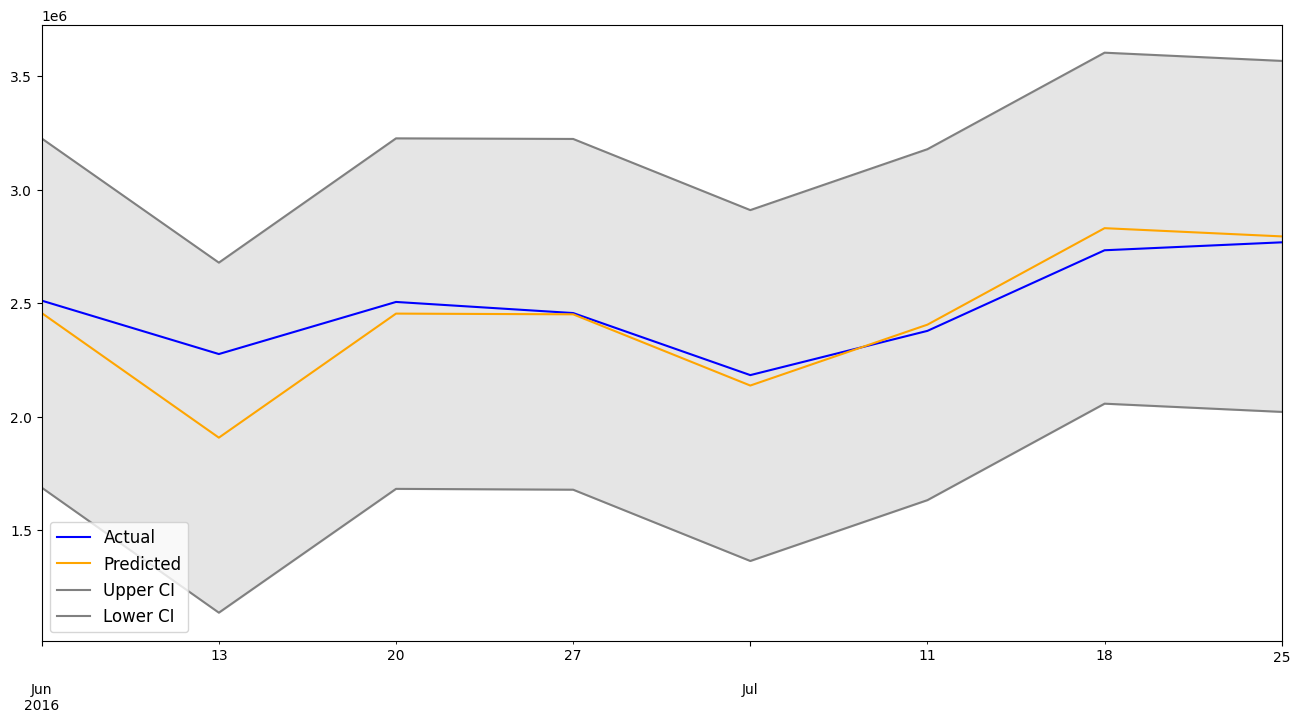

In [15]:
conf_df_arima = pd.concat([y_test, frame_arima[['mean','mean_ci_lower', 'mean_ci_upper']]], axis = 1)
conf_df_arima.columns=['Revenue','Predictions','Lower CI', 'Upper CI']
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)

x = conf_df_arima.index.values

upper_ci = conf_df_arima['Upper CI']
lower_ci = conf_df_arima['Lower CI']

conf_df_arima['Revenue'].plot(color = 'blue', label = 'Actual')
conf_df_arima['Predictions'].plot(color = 'orange',label = 'Predicted' )
upper_ci.plot(color = 'grey', label = 'Upper CI')
lower_ci.plot(color = 'grey', label = 'Lower CI')


plt.legend(loc = 'lower left', fontsize = 12)


plt.fill_between(x, lower_ci, upper_ci, color='grey', alpha=0.2)


plt.show()

Finally, we compute the MAE and RMSE, to draw our conclusion.

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(conf_df_arima['Revenue'],conf_df_arima['Predictions'])
rmse = mean_squared_error(conf_df_arima['Revenue'],conf_df_arima['Predictions'],squared=False)
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 84605.47400531292, RMSE: 138905.77467496306


We see that the MAE and RMSE are larger than the multiple linear regression model, which is as expected, as there are less than 5 seasonal period for SARIMAX model to be effective.



# Part 2: Bayesian methods

## 2a: Bayesian model estimation

### Bayesian Model with non-informative prior, Q2a(i)

We will fit our multiple linear regression model into a bayesian framework. Firstly, we will install the bambi package. The documentation can be found at https://bambinos.github.io/bambi/index.html.

In [17]:
pip install bambi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.8 MB/s eta 0:00:00


As the model expression `expr` is already defined in the Model Selection, Q1a(i) section, we will directly fit the expression into the default model in the bambi package. We print out the summary to see the explicit numbers.

In [18]:
import arviz as az
import bambi as bmb
az.style.use("arviz-darkgrid")
SEED = 12345

model = bmb.Model(expr, df.iloc[:200])
model

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 0.0, sigma: 8.2357)
            media2_S ~ Normal(mu: 0.0, sigma: 37.4497)
            media3_S ~ Normal(mu: 0.0, sigma: 19.8713)
            competitor_sales ~ Normal(mu: 0.0, sigma: 0.8691)
            newsletter ~ Normal(mu: 0.0, sigma: 99.1134)
        
        Auxiliary parameters
            revenue_sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)

All three media columns, competitor sales and newsletter have prior of the form Normal(0,sigma^2), and the standard deviation prior of revenue follows HalfStudentT distribution as shown in above. 

According to https://arxiv.org/abs/1702.01201, in these default priors, each non-zero parameter depends only on the partial correlation scale. Therefore, it is weakly informative.

If the prior was conjugate, the `revenue_sigma` would follow inverse gamma distribution, as shown in https://en.wikipedia.org/wiki/Bayesian_linear_regression. Since our `revenue_sigma` follows half student-t distribution instead, the prior is not conjugate.

We will use NUTS algorithm as developed in http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf. This is because HMC converges to the target distribution much faster than other other simpler methods. Among HMC algorithms, NUTS has the advantage that the user do not need to hand tune number of steps and step size.

### Convergence of MCMC chain, Q2a(ii)

To fit the model, one can simply use model.fit, as `bambi` automatically assigns NUTS for continuous variables.

In [19]:
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

We will take a look at the trace plot using `az.plot_trace()`.

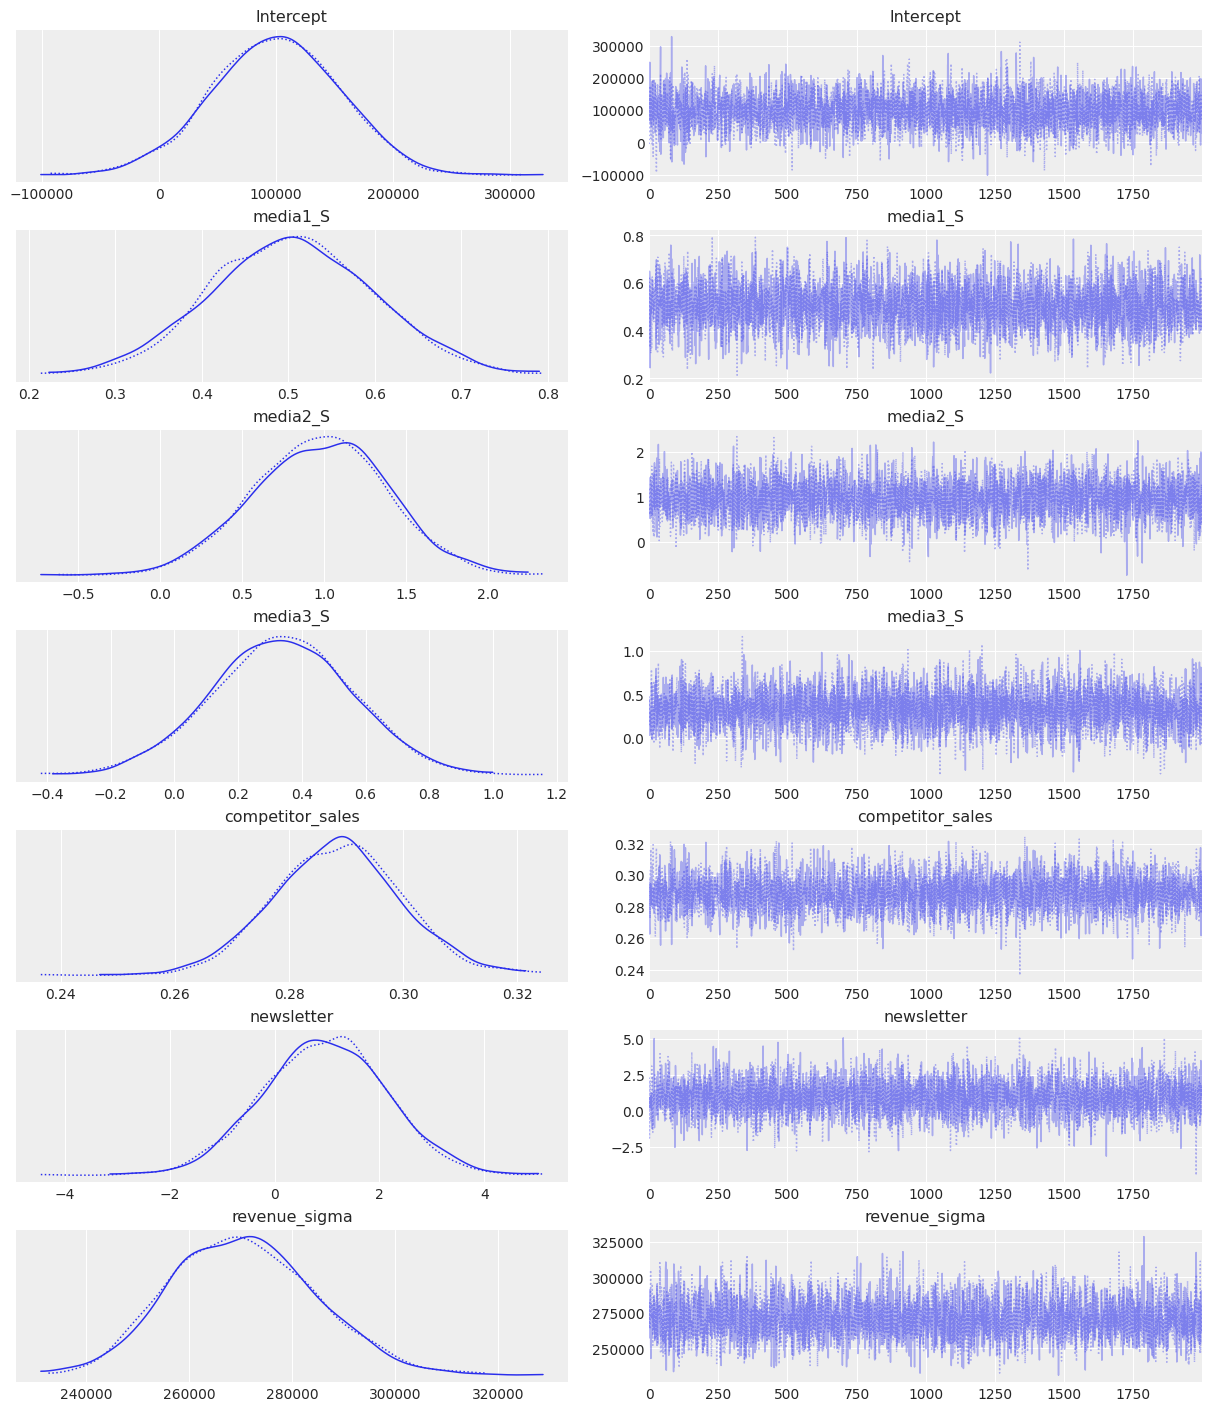

In [20]:
az.plot_trace(fitted);

We see that for all the parameters, the traces are oscillating about the mean, which is good because that means only white noise is left.

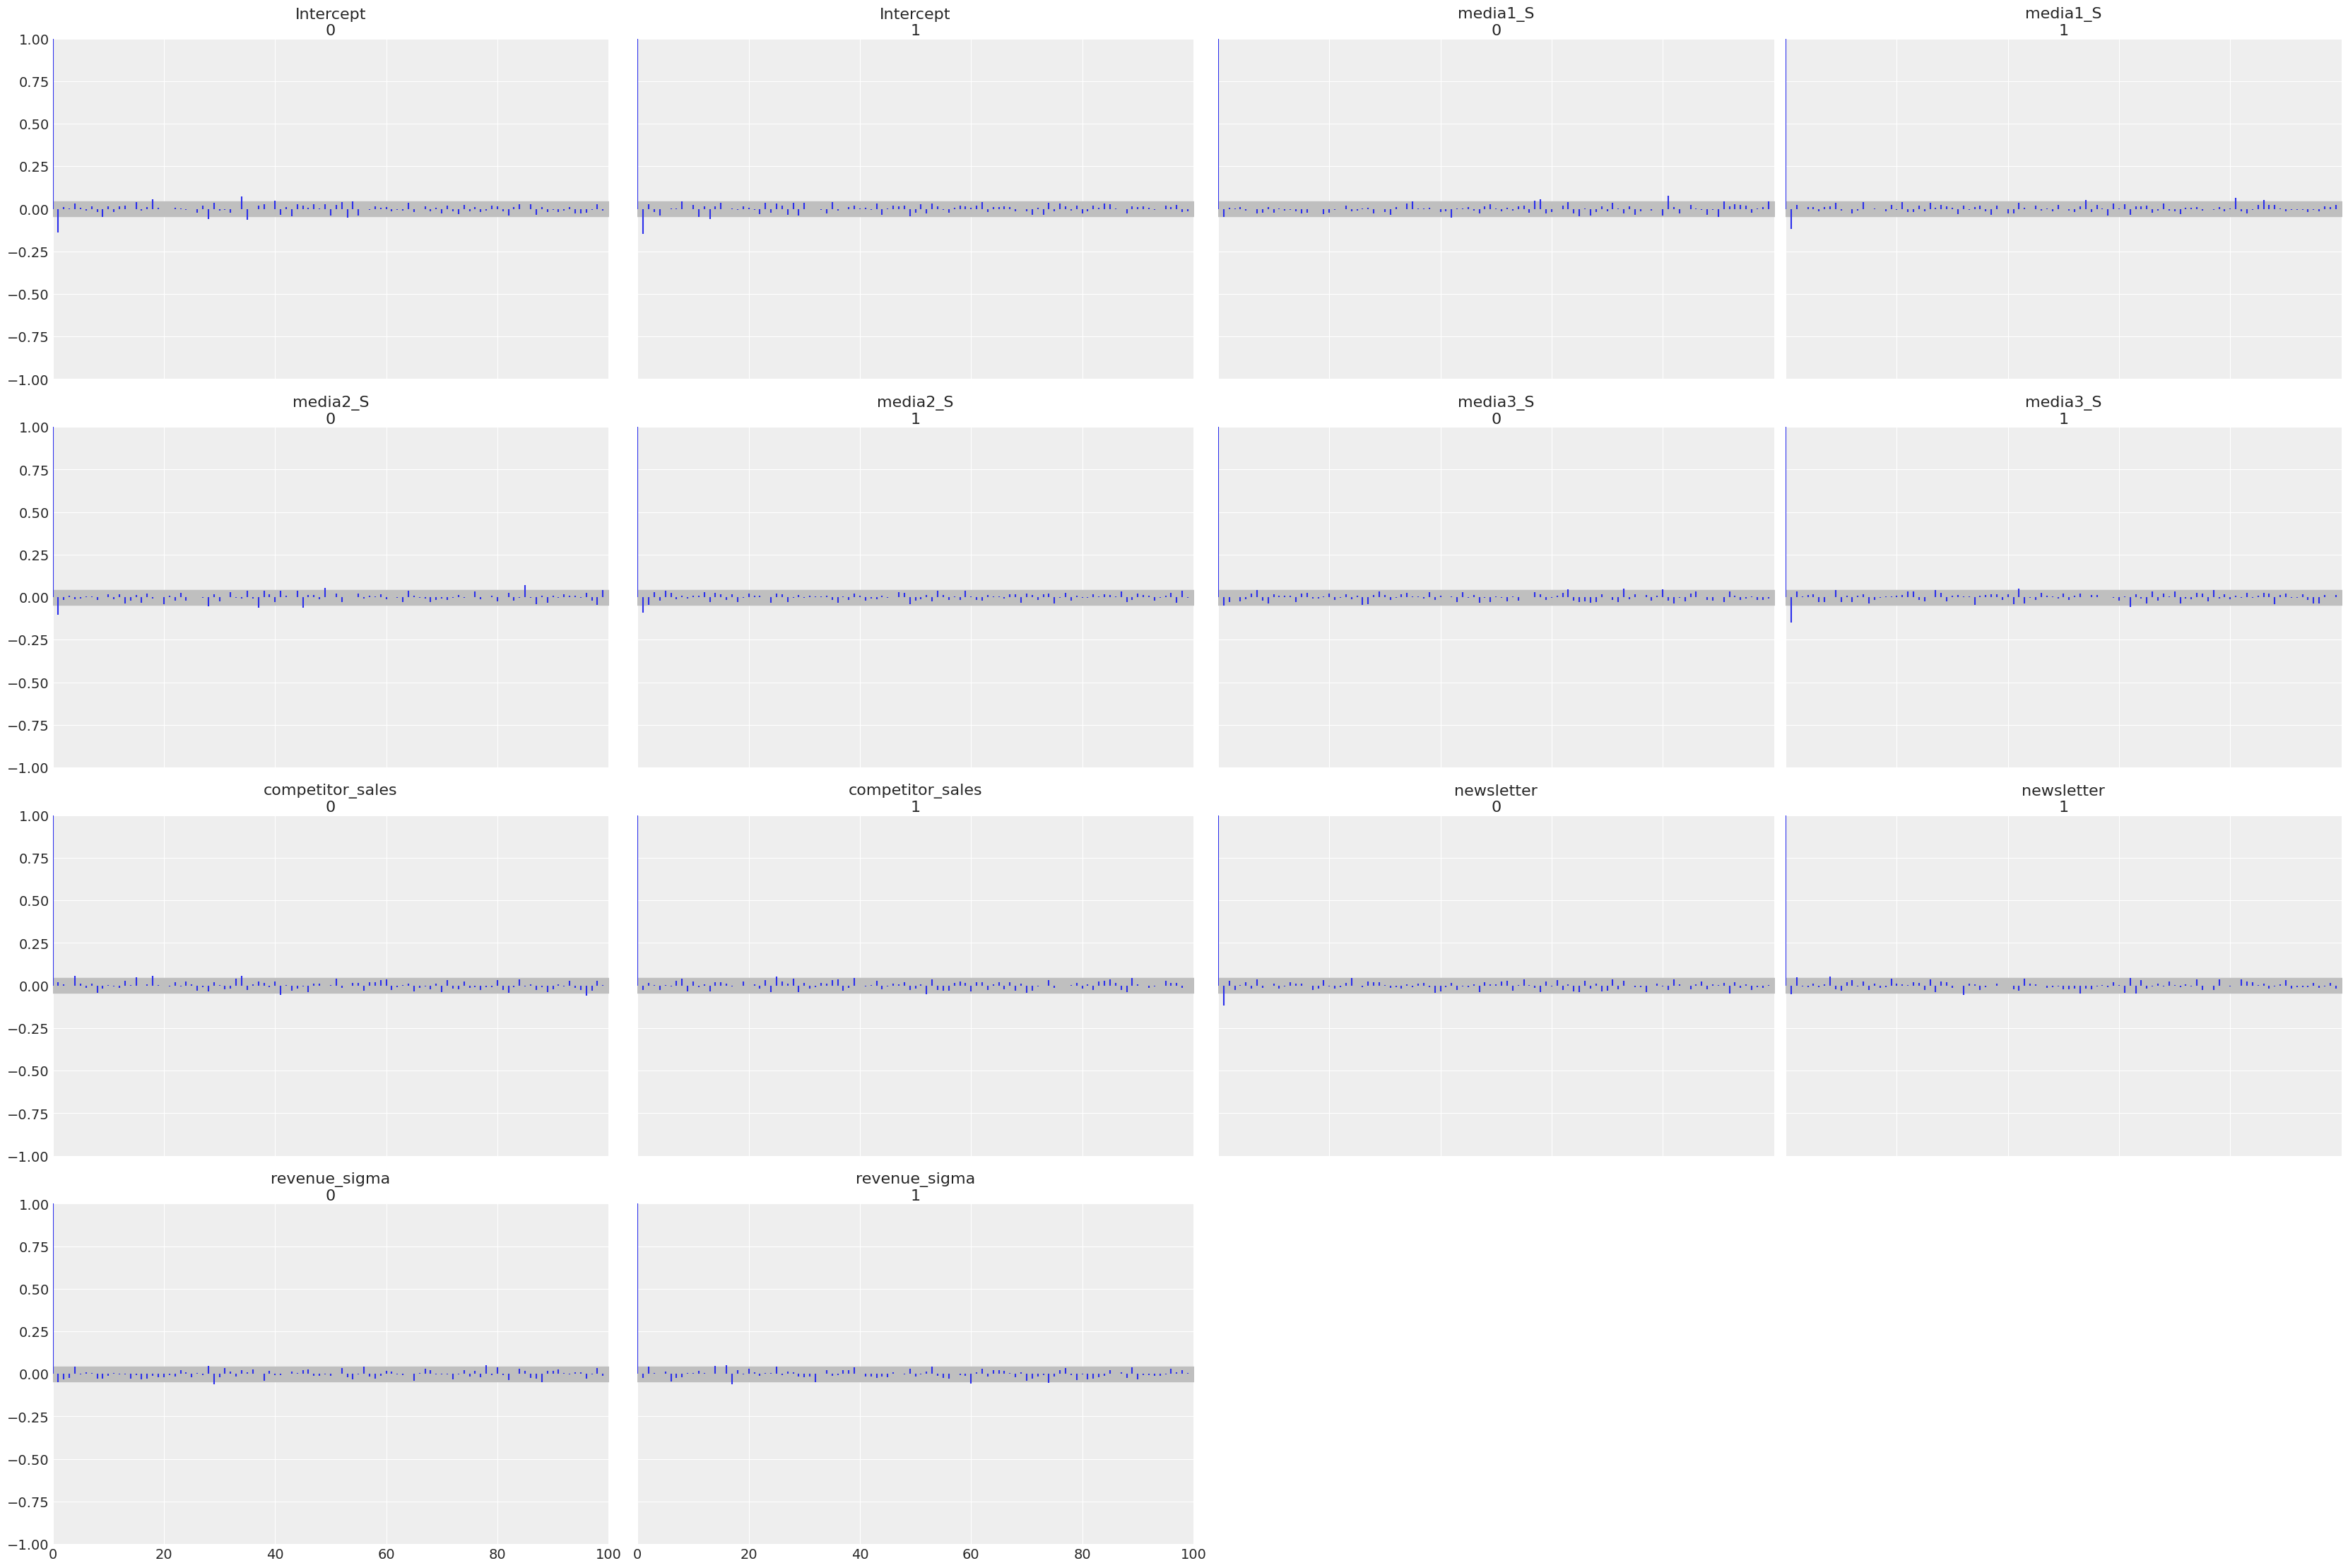

In [21]:
az.plot_autocorr(fitted);

All the plots have approximately 0 autocorrelation at each lag, which means the chains are likely to be independent.

### Summary, Q2a(iii)

We will print a summary here using `az.summary`.

In [22]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99560.990,54669.551,695.683,205089.951,740.172,576.370,5415.0,3487.0,1.0
media1_S,0.505,0.094,0.337,0.690,0.001,0.001,4521.0,3325.0,1.0
media2_S,0.973,0.408,0.198,1.733,0.006,0.004,4986.0,3337.0,1.0
media3_S,0.337,0.220,-0.060,0.770,0.003,0.003,4942.0,3321.0,1.0
competitor_sales,0.288,0.011,0.268,0.309,0.000,0.000,3755.0,2872.0,1.0
newsletter,0.943,1.176,-1.215,3.167,0.018,0.015,4323.0,3465.0,1.0
revenue_sigma,270518.212,13924.978,245959.563,297118.950,212.686,150.402,4302.0,3103.0,1.0


### Comparison, Q2a(iv)

To perform the comparison with classical multiple linear regression, lets once again print the summary from Model Selection, Q1a(i) section, and compare with the summary from previous section.

In [23]:
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     244.8
Date:                Thu, 11 May 2023   Prob (F-statistic):           9.58e-82
Time:                        15:25:28   Log-Likelihood:                -2781.0
No. Observations:                 200   AIC:                             5574.
Df Residuals:                     194   BIC:                             5594.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         9.959e+04   5.43e+04      1.835      0.068   -7448.972    2.07e+05
media1_S             0.5041      0.093      5.433      0.000       0.321       0.687
media2_S             0.9641      0.410      2.353      0.020       0.156       1.772
media3_S             0.3407      0.223      1.527      0.128      -0.099       0.781
competitor_sales     0.2885      0.011     25.959      0.000       0.267       0.310
newsletter           0.9219      1.164      0.792      0.429      -1.375       3.218
==============================================================================
Omnibus:                      186.740   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2503.306
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      18.577   Cond. No.                     1.66e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the mean and the standard deviation are very similar for two models. This is as expected as our priors are chosen as weakly informative, thus we are "letting the data speak", and the result should be close to classical multiple linear regression, as shown in the summaries.

## 2b: Prior choice

### Informative Prior, Q2b(i)

To combine the new belief "Media 3 has no impact in generating marketing revenues"  with information learned from the dataset, we can simply adjust the prior set for `media3_S` as say N(0,0.5^2), the distribution of coefficient for Media 3 will then be much closer to 0.

In [24]:
priors = {
    "media3_S": bmb.Prior("Normal", mu=0, sigma=0.5)
}
model.set_priors(priors)
model

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 0.0, sigma: 8.2357)
            media2_S ~ Normal(mu: 0.0, sigma: 37.4497)
            media3_S ~ Normal(mu: 0.0, sigma: 0.5)
            competitor_sales ~ Normal(mu: 0.0, sigma: 0.8691)
            newsletter ~ Normal(mu: 0.0, sigma: 99.1134)
        
        Auxiliary parameters
            revenue_sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### Estimation for informative prior, Q2b(ii)

Let's fit the model with the new prior.

In [25]:
fitted_new = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)
az.summary(fitted_new)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,97810.431,54863.250,99.523,207246.535,795.972,568.877,4735.0,3466.0,1.0
media1_S,0.505,0.095,0.330,0.686,0.001,0.001,4844.0,3098.0,1.0
media2_S,0.985,0.410,0.158,1.716,0.006,0.004,5175.0,3223.0,1.0
media3_S,0.283,0.204,-0.104,0.665,0.003,0.002,4792.0,3263.0,1.0
competitor_sales,0.289,0.011,0.269,0.310,0.000,0.000,4004.0,3162.0,1.0
newsletter,0.911,1.163,-1.295,3.039,0.017,0.014,4597.0,3114.0,1.0
revenue_sigma,270311.409,13881.696,244140.528,295935.807,211.948,149.880,4247.0,3351.0,1.0


Comparing the parameter with the non-informative prior, we have the following observations. 

The mean of coefficient `media3_S` decreases slightly only. We have tried to narrow down significantly about the distribution of coefficient of `media3_S`, however, that only results in small decrease in the coefficient. We conclude that the data is not supporting the belief.


### Additional Prior, Q2b(iii)

To incorporate the new beliefs, let us analyze one by one.
- “There is a strictly positive relationship between newsletter and marketing revenues.”

We can change the prior of newsletter from normal to half normal, thus forces the relationship to be positive. Since we would like to maintain the same variance, we need to scale down sigma by a factor of sqrt(1-2/pi), as in https://en.wikipedia.org/wiki/Half-normal_distribution.

- “I am fairly certain that one unit invested in Media 1 will result in two units of marketing revenues returned.” 

This basically means the coefficient of Media 1 should be 2. We simply modify the normal distribution to make it having mean 2.

- “I believe the impact of Media 2 is four times that of what I specified for Media 1.”

This means the coefficient of media 2 is 4 times coefficient of media 1. As the above prior makes coeffificient of media 2 ~ N(2,37.45^2) We can simply multiply it by 4, N(8,(4*37.45)^2)  
- “For every unit increase in competitor_sales, the change on revenues returned must range between 0 and 0.3.”

This means the coefficient of `competitor_sales` is in between 0 and 0.3. To be safe, we will take the prior that it follows N(0.15,1), as a wider prior is always preferred.

In [26]:
additional_priors = {
    "newsletter": bmb.Prior("HalfNormal", sigma=99.11*math.sqrt((1-2/math.pi))),
    "media1_S" : bmb.Prior("Normal",mu=2, sigma =37.45),
    'media2_S' : bmb.Prior("Normal",mu=8, sigma = 4*37.45),
    'competitor_sales' : bmb.Prior("Normal",mu=0.15,sigma=1)
}
model.set_priors(additional_priors)
model

       Formula: revenue ~ media1_S + media2_S + media3_S + competitor_sales + newsletter
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1795982.8917, sigma: 5799533.6451)
            media1_S ~ Normal(mu: 2.0, sigma: 37.45)
            media2_S ~ Normal(mu: 8.0, sigma: 149.8)
            media3_S ~ Normal(mu: 0.0, sigma: 0.5)
            competitor_sales ~ Normal(mu: 0.15, sigma: 1.0)
            newsletter ~ HalfNormal(sigma: 59.7445)
        
        Auxiliary parameters
            revenue_sigma ~ HalfStudentT(nu: 4.0, sigma: 715330.9566)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### Re-fit with Additional Prior, Q2b(iv)

In [27]:
fitted_additional = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)
az.summary(fitted_additional)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,100676.708,55027.642,-5619.109,200032.271,837.643,646.010,4306.0,2810.0,1.0
media1_S,0.508,0.094,0.331,0.678,0.001,0.001,4406.0,3048.0,1.0
media2_S,0.980,0.401,0.217,1.717,0.006,0.004,4759.0,2849.0,1.0
media3_S,0.283,0.203,-0.099,0.666,0.003,0.002,4333.0,2911.0,1.0
competitor_sales,0.287,0.011,0.266,0.307,0.000,0.000,3568.0,2449.0,1.0
revenue_sigma,270072.145,13657.284,243161.835,294249.399,205.815,146.296,4447.0,2800.0,1.0
newsletter,1.351,0.895,0.000,2.881,0.017,0.012,2053.0,1188.0,1.0


For the first additional belief, we conclude that the dataset is supporting it, as the distribution of newsletter is mostly centralized at positive values after fitting.

For the second and third addtional belief, we conclude the dataset is not supporting it. It is because the mean of coefficient of `media1_S` is only 0.51, significantly smaller than 2. Also, mean of coefficient of `media2_S` is only roughly 2 times of that of `media1_S`, not 4 times.

For the last additional belief, we conclude that the dataset is supporting it, as the mean of coefficient of `competitor_sales` is 0.287, and standard error is only 0.01. This shows that the distribution of coefficient of `competitor_sales` is mostly in between 0 and 0.3.